# Model to get started

* File name: model_to_get_started.ipynb
* Last edited: 2020-06-24
* Created by: Stefan Bruche (TU Berlin)

```python
import aristopy as ar

# Create basic energy system instance
es = ar.EnergySystem(
    number_of_time_steps=3, hours_per_time_step=1, 
    interest_rate=0.05, economic_lifetime=20)

# Add a gas source, two different conversion units and sinks
gas_source = ar.Source(
    ensys=es, name='gas_source', commodity_cost=20, outlet=ar.Flow('Fuel'))

gas_boiler = ar.Conversion(
    ensys=es, name='gas_boiler', basic_variable='Heat',
    inlet=ar.Flow('Fuel', 'gas_source'), outlet=ar.Flow('Heat', 'heat_sink'),
    capacity_max=150, capex_per_capacity=60e3, 
    user_expressions='Heat == 0.9 * Fuel')

chp_unit = ar.Conversion(
    ensys=es, name='chp_unit', basic_variable='Elec',
    inlet=ar.Flow('Fuel', 'gas_source'), 
    outlet=[ar.Flow('Heat', 'heat_sink'), ar.Flow('Elec', 'elec_sink')],
    capacity_max=100, capex_per_capacity=600e3,
    user_expressions=['Heat == 0.5 * Fuel', 
                      'Elec == 0.4 * Fuel'])

heat_sink = ar.Sink(
    ensys=es, name='heat_sink', inlet=ar.Flow('Heat'),
    commodity_rate_fix=ar.Series('heat_demand', [100, 200, 150]))

elec_sink = ar.Sink(
    ensys=es, name='elec_sink', inlet=ar.Flow('Elec'), commodity_revenues=30)

# Run the optimization
es.optimize(solver='cbc', results_file='results.json')

# Plot some results
plotter = ar.Plotter('results.json')
plotter.plot_operation('heat_sink', 'Heat', lgd_pos='lower center', 
                       bar_lw=0.5, ylabel='Thermal energy [MWh]')
plotter.plot_objective(lgd_pos='lower center')
```

### Create *aristopy* model

First, we need to import the *aristopy* package. If the import fails, you might need to recheck the installation instructions.

In [1]:
# Import the required packages (jupyter magic only required for jupyter notebooks)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import aristopy as ar

An *aristopy* model consists of an instance of the EnergySystem class and the added components. <br> 
To create an energy system, we need to specify the number of considered time steps and the number of hours per time step. Additionally, the interest rate and the economic lifetime of the installed components are required to calculate the net present value (objective function value).

In [2]:
# Create basic energy system instance
es = ar.EnergySystem(number_of_time_steps=3, hours_per_time_step=1,
                     interest_rate=0.05, economic_lifetime=20)

To instantiate a Component instance (Source, Sink, Conversion, Bus, Storage), we need to specify the EnergySystem instance, where it is added to and set a name for the component. Next, we add flows on the inlets and outlets. A Flow instance represents a connection point of a component and is used to create links with other components. Additionally, the flow introduces a commodity to the component and triggers the creation of an associated commodity variable (usually with the same name). The number of required or accepted inlet and outlet flows and component commodities depends on the component type (see table below). You can add multiple flows on an inlet or outlet for setting different commodities or linking components, by arranging them in a list.

| Component type | Nbr. of inlet flows | Nbr. of outlet flows | Nbr. of commodities |
| :---           | :---: | :---: | :---: |
| Source         | 0 | $\ge$ 1 | 1 |
| Sink           | $\ge$ 1 | 0 | 1 |
| Conversion     | $\ge$ 1 | $\ge$ 1 | $\ge$ 1 |
| Storage        | $\ge$ 1 | $\ge$ 1 | 1 |
| Bus            | $\ge$ 1 | $\ge$ 1 | 1 |



In [3]:
# Add a gas source
gas_source = ar.Source(ensys=es, name='gas_source', outlet=ar.Flow('Fuel'),
                       commodity_cost=20)

The conversion instances usually have different commodities on their inlets and outlets. That's why we need to specify the name of the basic variable for conversion components. This basic variable is used to restrict capacities, set operation rates, and calculate CAPEX and OPEX.

In [4]:
# Add a gas boiler conversion unit
gas_boiler = ar.Conversion(ensys=es, name='gas_boiler',
                           basic_variable='Heat',
                           inlet=ar.Flow(commodity='Fuel', link='gas_source'),
                           outlet=ar.Flow('Heat', 'heat_sink'),
                           capacity_max=150, capex_per_capacity=60e3,
                           user_expressions='Heat == 0.9 * Fuel')

We can use the keyword argument **user_expressions** to specify commodity conversion rates, limit capacities, and set other internal component constraints manually. Here we can use the names (identifiers) of the commodity variables created by adding flows, and, if applicable, variables with standard names, e.g.:

* CAP - component capacity variable
* BI_EX - binary existence variable
* BI_OP - binary operation variable
* ... (see file utils.py in your aristopy directory) 

The expressions are simply added as a list of strings. The options for mathematical operators are: <br> 
``sum, sin, cos, exp, log, ==, >=, <=, **, *, /, +, -, (, )``. <br> 
The indexes (sets) of the variables and parameters are processed automatically behind the scenes.

In [5]:
# Add a CHP unit
chp_unit = ar.Conversion(ensys=es, name='chp_unit', basic_variable='Elec',
                         inlet=ar.Flow('Fuel', 'gas_source'),
                         outlet=[ar.Flow('Heat', 'heat_sink'), ar.Flow('Elec', 'elec_sink')],
                         capacity_max=100, capex_per_capacity=600e3,
                         user_expressions=['Heat == 0.5 * Fuel',
                                           'Elec == 0.4 * Fuel'])

Time series data can be introduced as an aristopy Series instance and might be applied to set commodity rates, and time-dependent commodity cost or revenues, or generally for the scripting of user expressions.

In [6]:
# Add a sink with fixed heat demand
heat_sink = ar.Sink(ensys=es, name='heat_sink', inlet=ar.Flow('Heat'),
                    commodity_rate_fix=ar.Series('heat_demand', [100, 200, 150]))

elec_sink = ar.Sink(ensys=es, name='elec_sink', inlet=ar.Flow('Elec'),
                    commodity_revenues=30)

<div class="alert alert-info">

**Note:** 
    
Alternatively, we could use the *time_series_data* and *user_expressions* keyword arguments so set the required fixed commodity rate of the heat sink.
```python
heat_sink = ar.Sink(ensys=es, name='heat_sink', inlet=ar.Flow('Heat'),
                    time_series_data=ar.Series('heat_demand', [100, 200, 150]),
                    user_expressions='Heat == heat_demand')
```
</div>

### Run optimization

To run the optimization, we need to call the EnergySystem method *optimize*. The most important input to this method is the name of the applied solver. You have to ensure the solver is available on your machine and can be detected with this name. The solver output is suppressed for convenience in this notebook (*tee=False*). The results of the model run are written to a JSON-file with a specified name. 

In [7]:
es.optimize(solver='cbc', tee=False, results_file='results.json')

Basic information about the building and solving process of the optimzation model are stored in the Python dictionary *run_info* of the EnergySystem instane.

In [8]:
es.run_info

{'solver_name': 'cbc',
 'time_limit': None,
 'optimization_specs': '',
 'model_build_time': 0,
 'model_solve_time': 0,
 'upper_bound': 349147961.7,
 'lower_bound': 349147961.7,
 'sense': 'maximize',
 'solver_status': 'ok',
 'termination_condition': 'optimal'}

The pyomo ConcreteModel instance of the energy system can be accessed with the attribute *model*. All of the conventional pyomo functions can be applied here (e.g., pprint of the objective function).

In [9]:
es.model.Obj.pprint()

Obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : -249.24420685079974*(gas_source.Fuel[0,0] + gas_source.Fuel[0,1] + gas_source.Fuel[0,2])/0.00034246575342465754 - 60000.0*gas_boiler.CAP - 600000.0*chp_unit.CAP + 373.8663102761996*(elec_sink.Elec[0,0] + elec_sink.Elec[0,1] + elec_sink.Elec[0,2])/0.00034246575342465754


The component variables and constraints are stored in separate pyomo Block models. They can be accessed via attribute block directly on the components. All components are also added to EnergySystem's dictionary components and can be reached with their specified name.

In [10]:
gas_boiler.block.Heat.pprint()

Heat : Size=3, Index=time_set
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (0, 0) :     0 :   0.0 :  None : False : False : NonNegativeReals
    (0, 1) :     0 :  75.0 :  None : False : False : NonNegativeReals
    (0, 2) :     0 :  25.0 :  None : False : False : NonNegativeReals


In [11]:
# return dictionary of variable 'Elec' for component 'chp_unit'   
es.components['chp_unit'].block.Elec.get_values()

{(0, 0): 80.0, (0, 1): 100.0, (0, 2): 100.0}

### Plot results

The Plotter class is used to read the exported optimization results from the JSON-file and to provide basic plotting routines. Additional keyword arguments are available to customize the plotting output, e.g., set labels, figure size, legend position, etc. (see dictionary *props* of the Plotter class).

In [12]:
# Create instance of Plotter class and read in file 'results.json'
plotter = ar.Plotter('results.json')

The method *plot_operation* returns a mixed bar and line plot that visualizes the operation of a component on the
basis of a selected commodity.

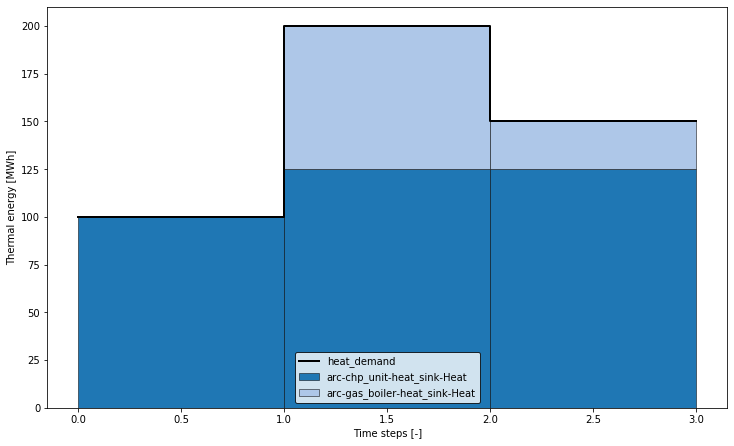

In [13]:
plotter.plot_operation('heat_sink', 'Heat', lgd_pos='lower center',
                       bar_lw=0.5, ylabel='Thermal energy [MWh]', 
                       show_plot=True)

The method *plot_objective* returns a bar chart that summarizes the cost contributions of each component to the
overall objective function value.

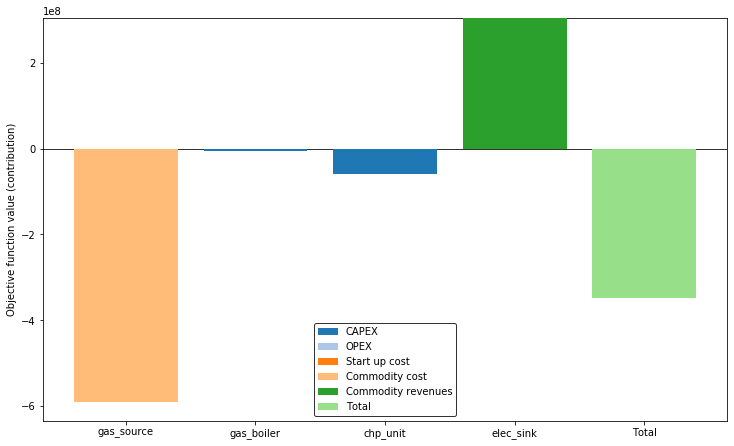

In [14]:
plotter.plot_objective(lgd_pos='lower center', show_plot=True)